# Importing necessary liberaries

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Loading dataset

In [34]:
# Load sample DataFrame
df = pd.read_excel("./cleanenergy1985.xlsx")

# List of countries and their respective DataFrames
countries = ['Congo', 'Turkey', 'Russia', 'China', 'United States']

In [35]:
df.head()

,country,Code,year,Other renewables (including geothermal and biomass) electricity generation - TWh,Solar generation - TWh,Wind generation - TWh,Hydro generation - TWh,Primary energy consumption per capita (kWh/person),population
0,Turkey,TUR,1985,0.0060,0.0,0.0,12.0449,7851.2905,49175680
1,Turkey,TUR,1986,0.0436,0.0,0.0,11.8726,8376.5490,50223890
2,Turkey,TUR,1987,0.0579,0.0,0.0,18.6178,9357.8950,51250156
3,Turkey,TUR,1988,0.0684,0.0,0.0,28.9496,10088.4860,52275892
4,Turkey,TUR,1989,0.0626,0.0,0.0,17.9396,9710.3530,53305236


In [36]:
df.tail()

,country,Code,year,Other renewables (including geothermal and biomass) electricity generation - TWh,Solar generation - TWh,Wind generation - TWh,Hydro generation - TWh,Primary energy consumption per capita (kWh/person),population
190,Congo,COG,2019,0.0,0.850000,0.0,0.090000,2873.820000,89906890
191,Congo,COG,2020,0.0,0.900000,0.0,0.060000,2379.556000,92853164
192,Congo,COG,2021,0.0,0.900000,0.0,0.060000,2348.011500,95894118
193,Congo,COG,2022,0.0,1.175195,0.0,0.065614,1688.341640,99010212
194,Congo,COG,2023,0.0,1.139675,0.0,0.068807,1271.098502,102262808


In [37]:
df.sample(5)

,country,Code,year,Other renewables (including geothermal and biomass) electricity generation - TWh,Solar generation - TWh,Wind generation - TWh,Hydro generation - TWh,Primary energy consumption per capita (kWh/person),population
153,Russia,RUS,2021,0.818994,2.312040,2.584840,214.53337,60271.0160,145102750
122,Russia,RUS,1990,0.065000,0.000000,0.000000,166.84561,68079.1600,148005700
159,Congo,COG,1988,0.000000,0.000000,0.000000,0.00000,1945.4266,33750052
123,Russia,RUS,1991,0.065000,0.000000,0.000000,168.09400,66946.9900,148455410
59,United States,USA,2005,72.598060,0.748901,17.990454,266.42773,90654.5300,296842660


# Helper function

In [38]:
# Function to create lag features
def create_lag_features(df, columns, lag=1):
    for col in columns:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Function to impute missing values
def impute_missing_values(df, method='mean'):
    for col in df.columns:
        if method == 'mean':
            df[col].fillna(df[col].mean(), inplace=True)
    return df

In [39]:
# Function to train model, evaluate, and forecast
def train_evaluate_forecast(df, features, target, split_ratio=0.6):
    # Split the data into training and testing sets
    split_index = int(len(df) * split_ratio)
    train_df, test_df = df[:split_index], df[split_index:]

    X_train, y_train = train_df[features], train_df[target]
    X_test, y_test = test_df[features], test_df[target]

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {country} - {target}: {mse}")

    # Forecasting for the entire dataset (including training data)
    df[f'{target}_pred'] = model.predict(df[features])

    return mse, model

# Data preparation and preprocessing

In [40]:
dfs = []

# Prepare DataFrames for each country
for country in countries:
    # Filter DataFrame for each country and drop unnecessary columns
    country_df = df[df['country'] == country].drop(columns=[
        'Other renewables (including geothermal and biomass) electricity generation - TWh',
        'Solar generation - TWh',
        'Wind generation - TWh',
        'Code',
        'country'
    ], axis=1)

    # Create lag features and impute missing values
    lagged_columns = ['Hydro generation - TWh', 'Primary energy consumption per capita (kWh/person)', 'population']
    country_df = create_lag_features(country_df, lagged_columns, lag=1)
    country_df.drop(columns=['Primary energy consumption per capita (kWh/person)', 'population'], inplace=True)
    country_df = impute_missing_values(country_df, method='mean')
    dfs.append(country_df)

In [41]:
# List of features for modeling
features = ['year', 'Hydro generation - TWh_lag1', 'Primary energy consumption per capita (kWh/person)_lag1', 'population_lag1']
target = 'Hydro generation - TWh'

# Model training and evaluation

### Splitting ratio = 60%

In [42]:
# Train, evaluate, and forecast for each country
mses = {}
models = {}
for country, country_df in zip(countries, dfs):
    mse, model = train_evaluate_forecast(country_df, features, target)
    mses[country] = mse
    models[country] = model

Mean Squared Error for Congo - Hydro generation - TWh: 0.000601967345567091
Mean Squared Error for Turkey - Hydro generation - TWh: 369.6665475062212
Mean Squared Error for Russia - Hydro generation - TWh: 108.4472268609678
Mean Squared Error for China - Hydro generation - TWh: 119783.94651730628
Mean Squared Error for United States - Hydro generation - TWh: 4494.668659011812


# MSE scores

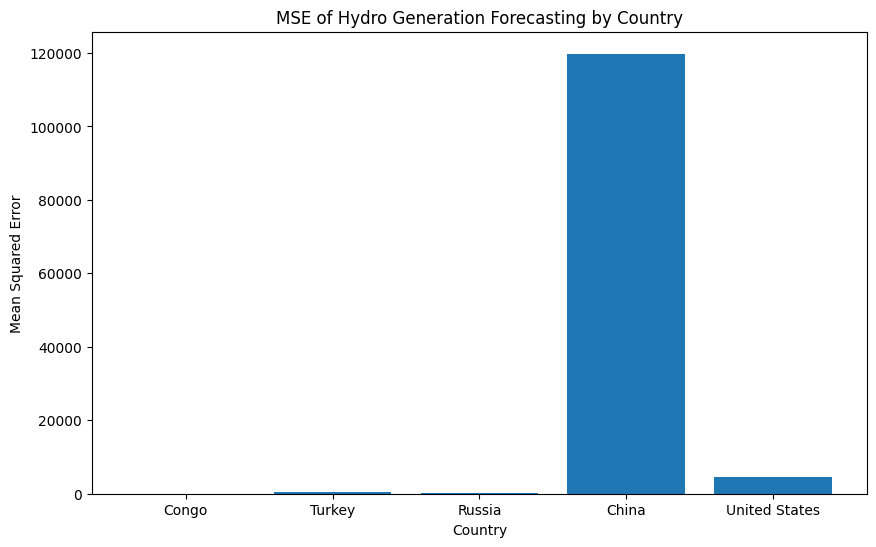

In [43]:
# Plotting MSE scores
plt.figure(figsize=(10, 6))
plt.bar(mses.keys(), mses.values())
plt.xlabel('Country')
plt.ylabel('Mean Squared Error')
plt.title('MSE of Hydro Generation Forecasting by Country')
plt.show()

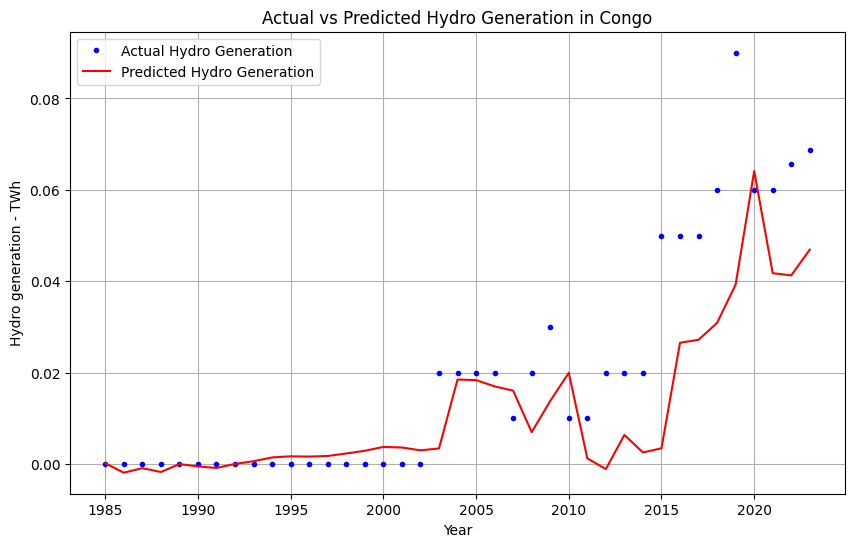

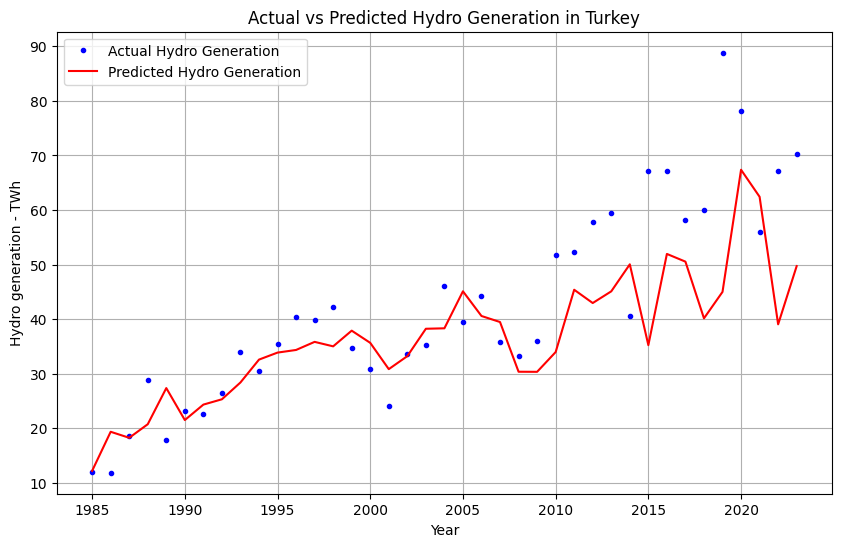

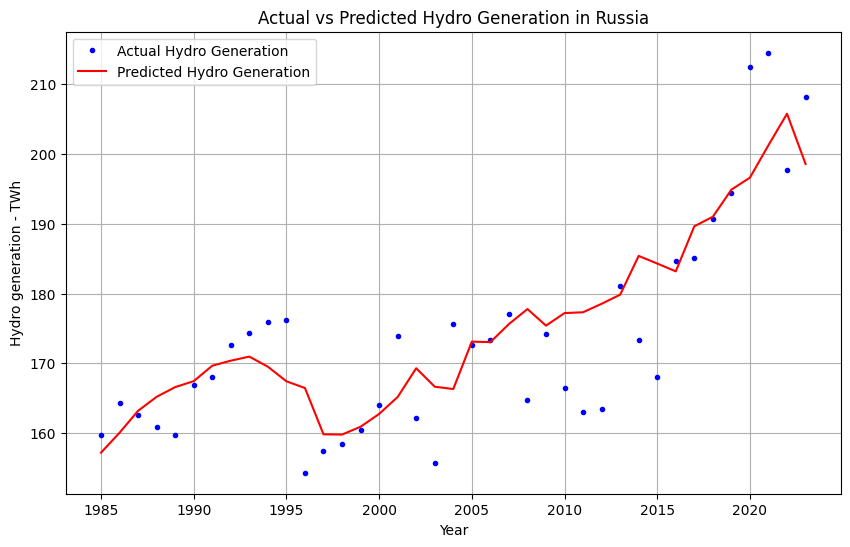

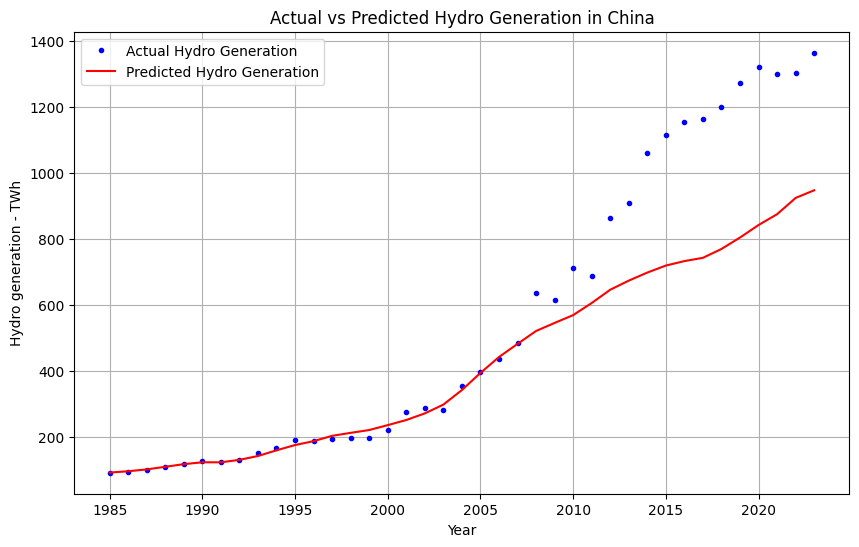

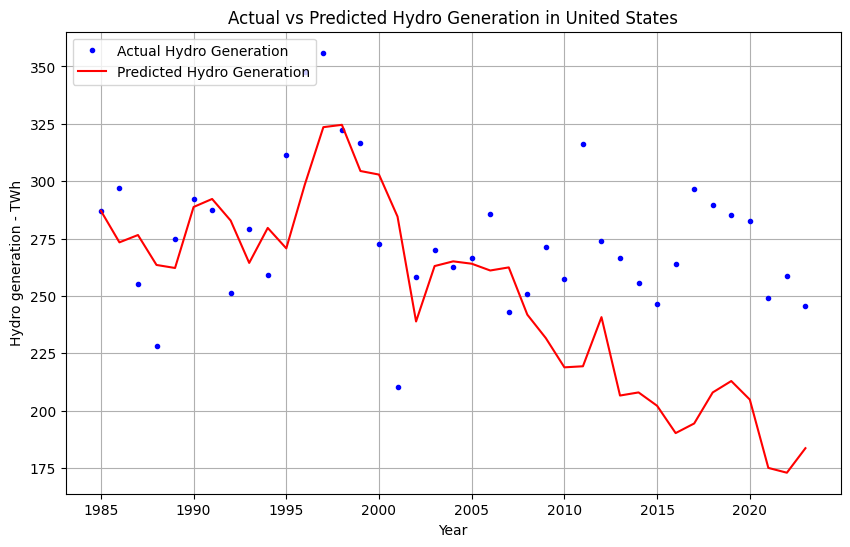

In [44]:
# Plotting the actual values and the regression line for each country
for country, country_df in zip(countries, dfs):
    # Extracting the actual values
    actual_years = country_df['year']
    actual_hydro_generation = country_df['Hydro generation - TWh']

    # Extracting the predicted values
    predicted_hydro_generation = country_df['Hydro generation - TWh_pred']

    plt.figure(figsize=(10, 6))
    plt.plot(actual_years, actual_hydro_generation, 'b.', label='Actual Hydro Generation')
    plt.plot(actual_years, predicted_hydro_generation, 'r-', label='Predicted Hydro Generation')
    plt.xlabel('Year')
    plt.ylabel('Hydro generation - TWh')
    plt.title(f'Actual vs Predicted Hydro Generation in {country}')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()


#Prediction for the next 10 years




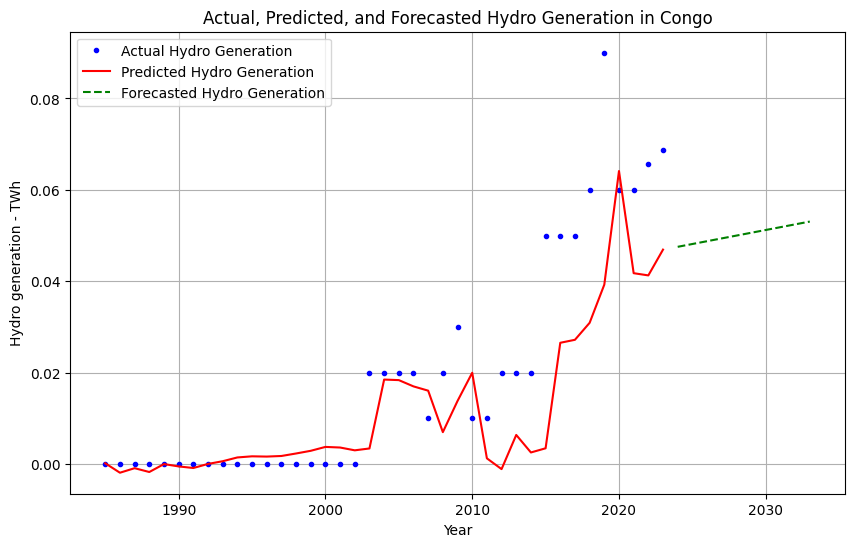

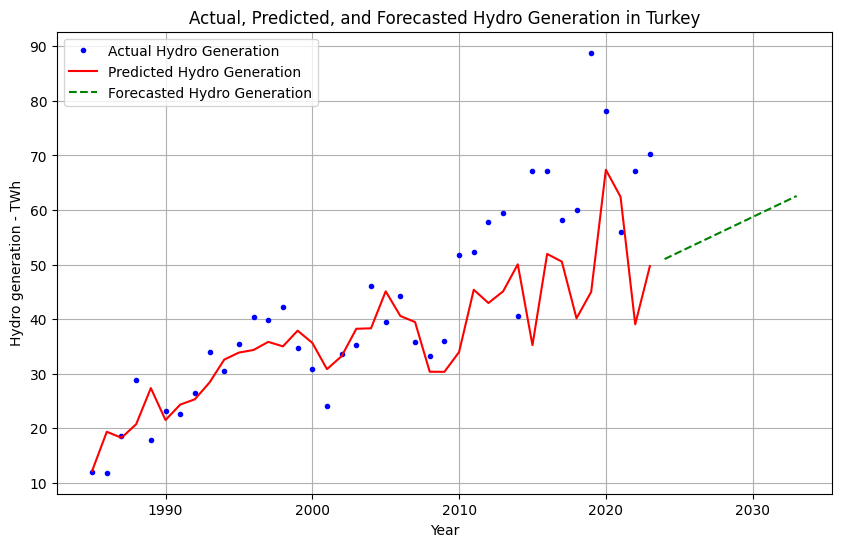

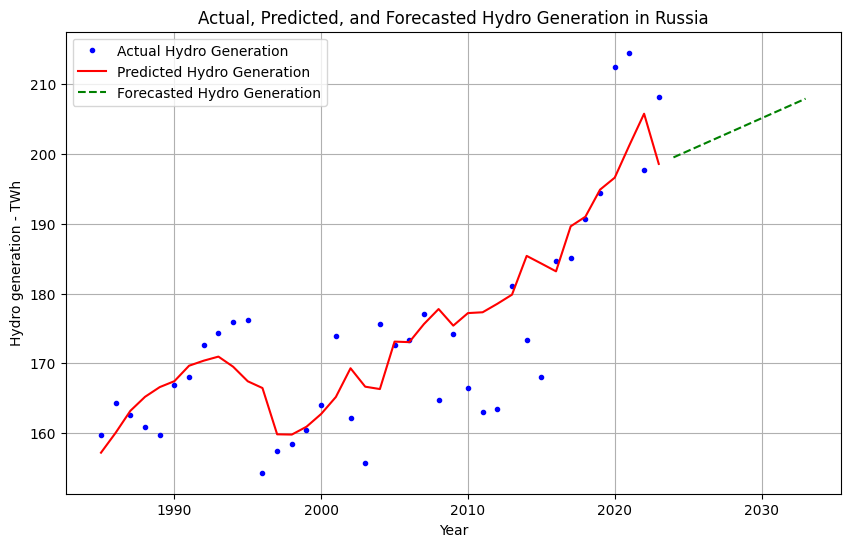

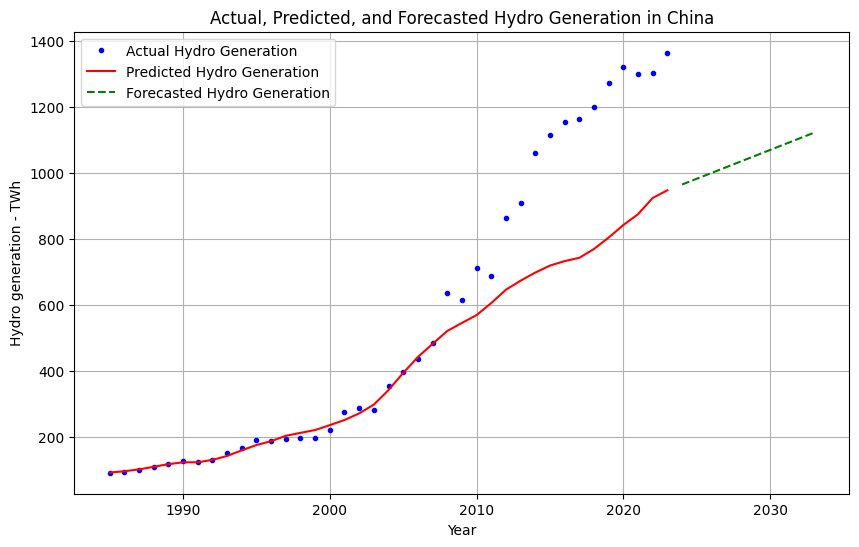

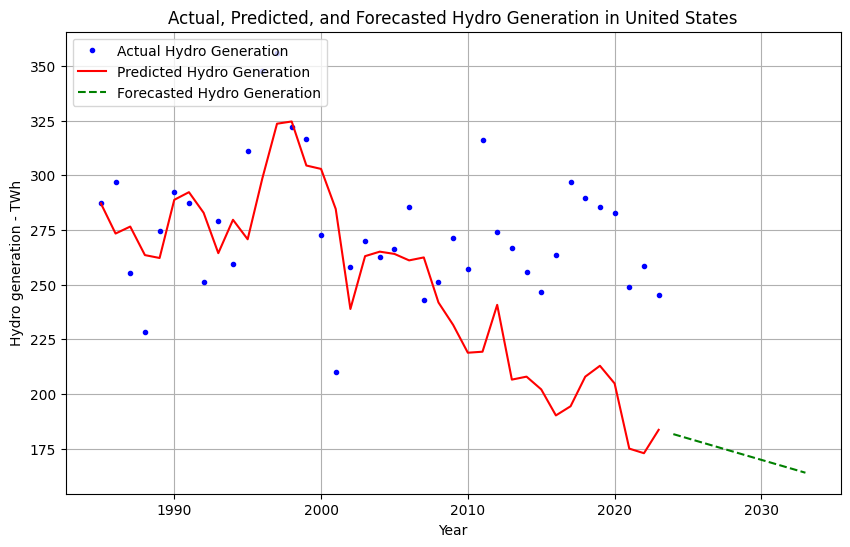

In [50]:
# Function to forecast the next 10 years
def forecast_next_5_years(country_df, model, features, target, start_year, num_years=10):
    # Create a DataFrame to store the future years
    future_years = pd.DataFrame({
        'year': np.arange(start_year, start_year + num_years)
    })

    # Get the last row of the original DataFrame to use as the base for future predictions
    last_row = country_df.iloc[-1]

    # Create lag features for the future years
    future_rows = []
    for year in future_years['year']:
        future_year = {
            'year': year,
            'Hydro generation - TWh_lag1': last_row['Hydro generation - TWh_lag1'],
            'Primary energy consumption per capita (kWh/person)_lag1': last_row['Primary energy consumption per capita (kWh/person)_lag1'],
            'population_lag1': last_row['population_lag1']
        }
        future_rows.append(future_year)
        last_row = pd.Series(future_year)

    future_years = pd.DataFrame(future_rows)

    # Predict the hydro energy production for the future years
    future_years[target] = model.predict(future_years[features])

    return future_years

# Example usage:
# Get the last year in the current dataset
start_year = df['year'].max() + 1

# Use the previously trained models to forecast the next 5 years for each country
future_forecasts = {}
for country, country_df in zip(countries, dfs):
    future_forecasts[country] = forecast_next_5_years(country_df, models[country], features, target, start_year)

# Plot the actual, predicted, and forecasted values for each country
for country, country_df in zip(countries, dfs):
    # Extracting the actual values
    actual_years = country_df['year']
    actual_hydro_generation = country_df['Hydro generation - TWh']

    # Extracting the predicted values
    predicted_hydro_generation = country_df['Hydro generation - TWh_pred']

    # Extracting the forecasted values
    forecasted_years = future_forecasts[country]['year']
    forecasted_hydro_generation = future_forecasts[country]['Hydro generation - TWh']

    plt.figure(figsize=(10, 6))
    plt.plot(actual_years, actual_hydro_generation, 'b.', label='Actual Hydro Generation')
    plt.plot(actual_years, predicted_hydro_generation, 'r-', label='Predicted Hydro Generation')
    plt.plot(forecasted_years, forecasted_hydro_generation, 'g--', label='Forecasted Hydro Generation')
    plt.xlabel('Year')
    plt.ylabel('Hydro generation - TWh')
    plt.title(f'Actual, Predicted, and Forecasted Hydro Generation in {country}')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

# K-means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Congo - Cluster 1
Turkey - Cluster 1
Russia - Cluster 3
China - Cluster 2
United States - Cluster 3


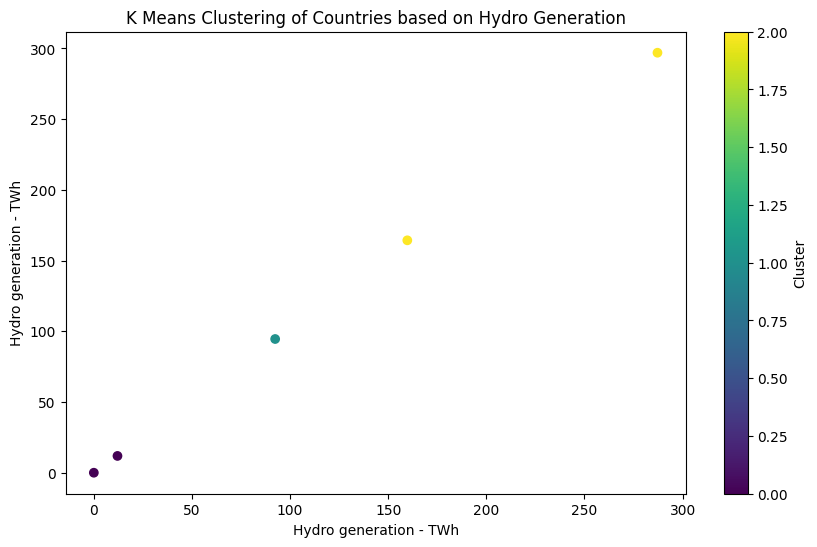

In [46]:
# Extracting hydro generation data for clustering
hydro_generation_data = np.array([country_df[target].values for country_df in dfs])

# Perform K Means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(hydro_generation_data)

# Get cluster labels for each country
cluster_labels = kmeans.labels_

# Print the cluster labels for each country
for country, label in zip(countries, cluster_labels):
    print(f"{country} - Cluster {label+1}")

# Plotting the clustering result
plt.figure(figsize=(10, 6))
plt.scatter(hydro_generation_data[:, 0], hydro_generation_data[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Hydro generation - TWh')
plt.ylabel('Hydro generation - TWh')
plt.title('K Means Clustering of Countries based on Hydro Generation')
plt.colorbar(label='Cluster')
plt.show()


In [1]:
!pip install plotly

^C


In [53]:
import plotly.express as px
# Summing hydro generation by country
total_solar_generation = df.groupby('country')[['Hydro generation - TWh']].sum().reset_index()

# Rename columns for easier plotting
total_solar_generation.columns = ['country', 'hydro_generation_TWh']

# Create a pie chart with Plotly Express
fig = px.pie(
    total_solar_generation,
    values='hydro_generation_TWh',
    names='country',
    title='Total Hydro Energy Generation by Country',
    color_discrete_sequence=px.colors.qualitative.Set3,  # Use Set3 for more appealing colors
    hole=0.4  # To create a donut chart
)

# Customize the hoverinfo and labels
fig.update_traces(
    textinfo='percent+label',
    textposition='outside',
    marker=dict(line=dict(color='black', width=2))
)

# Adjust the layout for better readability
fig.update_layout(
    title_font_size=18,
    legend_title_text='Countries',
    legend_font_size=12,
    margin=dict(t=80, b=0, l=0, r=0)
)

# Display the chart
fig.show()

# Evaluation of k-means

In [47]:
# Evaluate the clustering

#inertia: which gives an idea of how tightly the clusters are formed.
inertia = kmeans.inertia_

#silhouette_avg: This metric is between -1 and 1, where a value close to 1 means the clusters are well-separated.
silhouette_avg = silhouette_score(hydro_generation_data, cluster_labels)

#davies_bouldin: calculates the Davies-Bouldin index for the clustering, where a lower score is better.
davies_bouldin = davies_bouldin_score(hydro_generation_data, cluster_labels)

print(f"Inertia: {inertia}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Inertia: 270539.6114911528
Silhouette Score: 0.4827845130479176
Davies-Bouldin Index: 0.28525803757558893


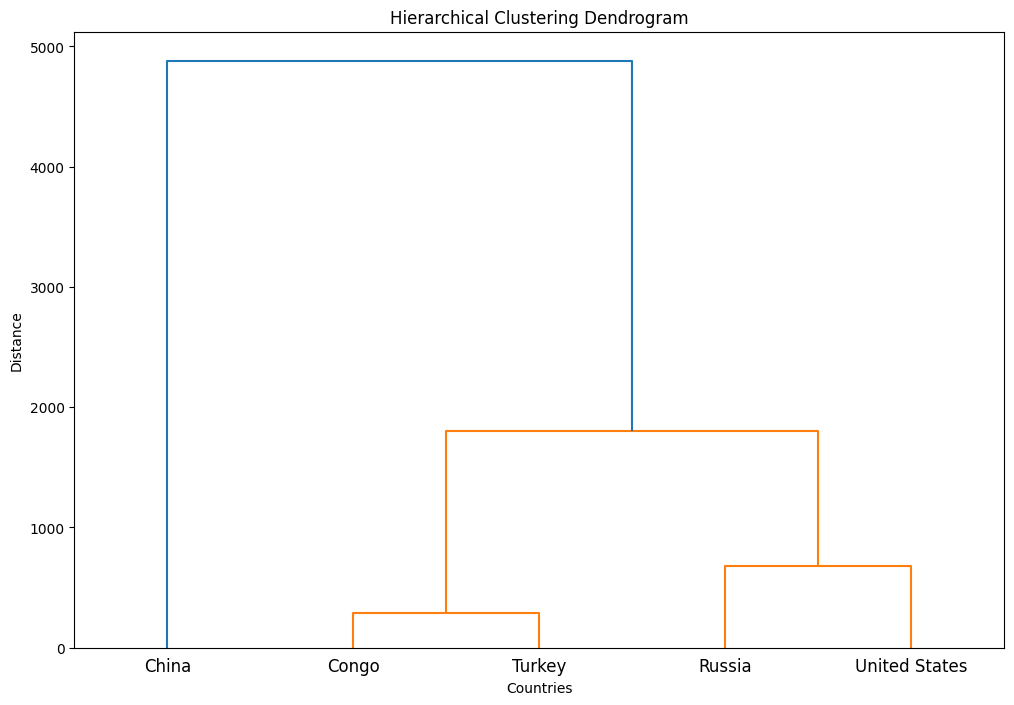

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
Z = linkage(hydro_generation_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=countries)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()


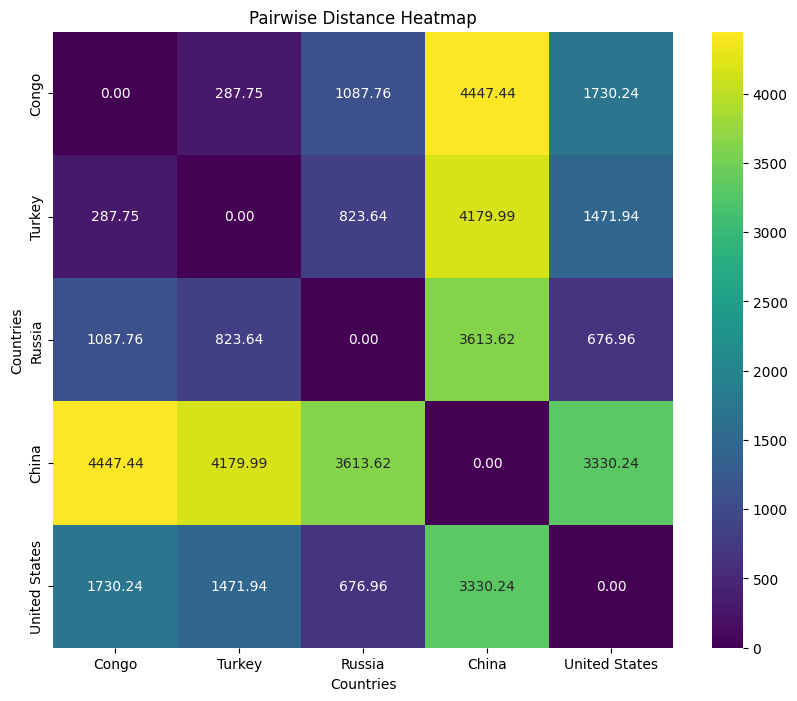

In [49]:
# Calculate pairwise distances between countries
from sklearn.metrics import pairwise_distances

# Calculate pairwise distances
distances = pairwise_distances(hydro_generation_data, metric='euclidean')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distances, annot=True, fmt=".2f", xticklabels=countries, yticklabels=countries, cmap='viridis')
plt.title('Pairwise Distance Heatmap')
plt.xlabel('Countries')
plt.ylabel('Countries')
plt.show()